# Few tests on the integration efficience

In [2]:
### libraries
import sys

sys.path.append('../')

import Velocity_dispersion
import rings2cosmo
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import seaborn

from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 67.3, Om0 = 0.315)

In [3]:
numerical = pd.read_csv('results.csv')
numerical.head()

,name,numerical_sigma,integral_result,integral_error,epsabs
0,J2321-0939,240.101777,7446.749998,7.946850e+07,0.149
1,J1106+5228,222.047668,6932.458429,6.784547e+07,0.149
2,J1143-0144,264.867997,10395.782864,9.643616e+07,0.149
3,J0841+3824,230.106668,8225.243472,7.272054e+07,0.149
4,J0044+0113,252.925493,10113.812560,8.628597e+07,0.149


## Performance evaluation

<AxesSubplot:xlabel='epsabs', ylabel='integral_error'>

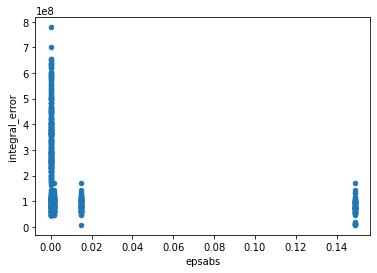

In [40]:
numerical.plot.scatter("epsabs", "integral_error")

,name,numerical_sigma,integral_result,integral_error,epsabs
0,J2321-0939,240.101777,7446.749998,7.946850e+07,0.149
1,J1106+5228,222.047668,6932.458429,6.784547e+07,0.149
2,J1143-0144,264.867997,10395.782864,9.643616e+07,0.149
3,J0841+3824,230.106668,8225.243472,7.272054e+07,0.149
4,J0044+0113,252.925493,10113.812560,8.628597e+07,0.149


## The relative error
The code solves numerically thi equation

$$2\int_0^{\infty}\int_R^{\infty}\omega(R)\frac{\nu(r)\sigma^2_r(r)}{\sqrt{r^2 - R^2}}\left (1 - \beta\frac{R^2}{r^2}\right )rdrRdR$$

which has an analitical result

$$ =  \left [\frac{1}{1 + \gamma}\frac{c^2}{2}\frac{Ds}{Dsl}\theta_E \right ] 
\frac{2}{\sqrt{\pi}\lambda(\alpha)(\xi - 2\beta)}\left (\frac{1}{R_E}\right )^{2 - \alpha}\sqrt{\pi}\left [ \lambda (\xi)
   - \beta \lambda(\xi + 2) \right ](2D_L^2\tilde{\sigma}^2_{atm})^{(3-\xi)/2}\frac{1}{2} \Gamma\left ( \frac{3 - \xi}{2} \right ) $$




In [4]:
data = pd.read_csv('../data/sample80.csv')
data.head()

,name,zl,zs,sigma_0,dsigma_0,theta_E,theta_ap,sigma_atm,sigma_ap,d_sigma_ap
0,J2321-0939,0.082,0.532,246,8,1.60,1.5,1.4,249,8
1,J1106+5228,0.096,0.407,268,13,1.23,1.5,1.4,262,13
2,J1143-0144,0.106,0.402,264,13,1.68,1.5,1.4,269,13
3,J0841+3824,0.116,0.657,222,11,1.41,1.5,1.4,225,11
4,J0044+0113,0.120,0.196,267,13,0.79,1.5,1.4,266,13


In [10]:
def analitical_integral(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha,  delta, beta, gamma):
    # Angular diameter distances:
    DS = cosmo.angular_diameter_distance(z_S).value
    DL = cosmo.angular_diameter_distance(z_L).value
    DLS = cosmo.angular_diameter_distance_z1z2(z_L, z_S).value
    RE = theta_E*DL 
    
    c = (const.c).to(u.km/u.second) #light velocity in Km/s This is bc velocity dispersion is measured in (km/s)^2
    clight = c.value
     # \tilde{\sigma}
    chi = theta_ap/seeing_atm

    tilde_sigma = seeing_atm * \
        np.sqrt(1 + (chi ** 2) / 4 + (chi ** 4) / 40)  # Eq. (20)
    
    xi = alpha + delta - 2    
    
    ## constant 
    term_RE  = (1 / (1 + gamma)) * ((clight ** 2) / 2) * (DS / DLS) * theta_E
    term_dynamic = 2/(((np.sqrt(np.pi)))*(Velocity_dispersion.Lambda_function(alpha))*(xi - (2*beta)))
    cte = term_RE*term_dynamic/(RE**(2 - alpha))
    
    ##integral
    x = (3 - xi)/2

    #beta_term = sp.special.beta((xi - 1)/2,0.5) -  (beta*sp.special.beta((xi + 1)/2,0.5))
    beta_term = np.sqrt(np.pi)*(Velocity_dispersion.Lambda_function(xi) - beta*Velocity_dispersion.Lambda_function(xi + 2))
    seeing_term = 2*(DL**2)*(tilde_sigma**2)
    gamma_term = sp.special.gamma(x)

    return cte*beta_term*(seeing_term**x)*gamma_term/2

In [14]:
#### just to test if the above function is working #####
### variables and unity convesion

z_L = data['zl'][0]
z_S = data['zs'][0]
theta_E = (data['theta_E'].values * u.arcsec).to(u.rad)[0].value
theta_ap = (data['theta_ap'].values * u.arcsec).to(u.rad)[0].value
seeing_atm = (data['sigma_atm'].values * u.arcsec).to(u.rad)[0].value
velDisp = data['sigma_ap'][0]
velDispErr = data['d_sigma_ap'][0]
#parameters not related to data
alpha = 2.0
beta = 0.18
delta = 2.4
gamma = 1.0

analitical_integral(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha,  delta, beta, gamma)

7610.464774939843

In [15]:
#### Now I will create a data frame to compare with the numerical integral

Analitical = []
cols = ("name", "z_S", "z_L", "theta_E", "theta_ap","seeing_atm",  "analitical_result")

alpha = 2.0
beta = 0.18
delta = 2.4
gamma = 1.0
epsabs_values = (1.49e-01, 1.49e-02, 1.49e-03, 1.49e-04, 1.49e-05, 1.49e-06, 1.49e-07, 1.49e-08)
data = pd.read_csv('../data/sample80.csv')

for i in range(len(data)):
    ## data
    name = data['name'][i]
    z_L = data['zl'][i]
    z_S = data['zs'][i]
    theta_E = (data['theta_E'].values * u.arcsec).to(u.rad)[i].value
    theta_ap = (data['theta_ap'].values * u.arcsec).to(u.rad)[i].value
    seeing_atm = (data['sigma_atm'].values * u.arcsec).to(u.rad)[i].value
        
    analitical_result = analitical_integral(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha,  delta, beta, gamma)
        
    temp = (name, z_S, z_L, theta_E, theta_ap, seeing_atm, analitical_result)
    Analitical.append (dict(zip(cols,temp)))
        

In [16]:
Analitical = pd.DataFrame(Analitical)
Analitical.head()

,name,z_S,z_L,theta_E,theta_ap,seeing_atm,analitical_result
0,J2321-0939,0.532,0.082,0.000008,0.000007,0.000007,7610.464775
1,J1106+5228,0.407,0.096,0.000006,0.000007,0.000007,7072.221482
2,J1143-0144,0.402,0.106,0.000008,0.000007,0.000007,10594.446458
3,J0841+3824,0.657,0.116,0.000007,0.000007,0.000007,8375.053857
4,J0044+0113,0.196,0.120,0.000004,0.000007,0.000007,10113.699232


In [18]:
Analitical.dtypes

name                  object
z_S                  float64
z_L                  float64
theta_E              float64
theta_ap             float64
seeing_atm           float64
analitical_result    float64
dtype: object

So now I will compare the results

(array([20.,  0.,  0.,  0.,  3., 19., 22.,  8.,  6.,  2.]),
 array([1.04528515e-04, 2.14631530e-01, 4.29158531e-01, 6.43685532e-01,
        8.58212533e-01, 1.07273953e+00, 1.28726654e+00, 1.50179354e+00,
        1.71632054e+00, 1.93084754e+00, 2.14537454e+00]),
 <BarContainer object of 10 artists>)

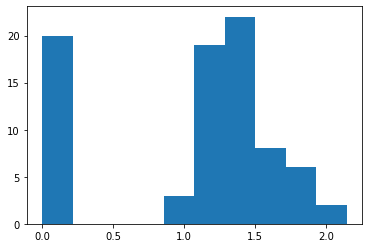

In [32]:
df_n04 = numerical[numerical["epsabs"] == 1.49e-04]
df_n04 = df_n04.set_index('name').join(Analitical.set_index('name'))
### to calculate the relative error
errors = []

for i in df_n04.index:
    errors.append(abs(df_n04['integral_result'][i] - df_n04['analitical_result'][i])/df_n04['analitical_result'][i]*100)
    
plt.hist(errors)

(array([21.,  0.,  0.,  0.,  3., 18., 22.,  8.,  6.,  2.]),
 array([8.31623600e-05, 2.15465393e-01, 4.30847624e-01, 6.46229855e-01,
        8.61612085e-01, 1.07699432e+00, 1.29237655e+00, 1.50775878e+00,
        1.72314101e+00, 1.93852324e+00, 2.15390547e+00]),
 <BarContainer object of 10 artists>)

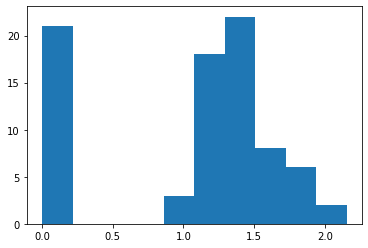

In [31]:
df_n08 = numerical[numerical["epsabs"] == 1.49e-08]
df_n08 = df_n08.set_index('name').join(Analitical.set_index('name'))
errors = []

for i in df_n08.index:
    errors.append(abs(df_n08['integral_result'][i] - df_n08['analitical_result'][i])/df_n08['analitical_result'][i]*100)
    
plt.hist(errors)


$$
 \left \langle \sigma^2_{LOS,*} \right \rangle =  \left [ \frac{1}{1 + \gamma}\frac{c^2}{2}\frac{D_s}{D_{ls}}\theta_E \right ]\frac{2}{\sqrt{\pi}\lambda(\alpha)(\xi - 2\beta)}\frac{\left [ \lambda(\xi) - \beta\lambda(\xi + 2) \right ]}{\lambda(\delta)} \left(\frac{2\tilde{\sigma}^2_{atm}}{\theta_E^2}\right)^{(2-\alpha)/2} \frac{\Gamma\left ( \frac{3 - \xi}{2} \right )}{\Gamma\left ( \frac{3 - \delta}{2} \right )}
$$


### About pandas
- to filter

``` python

df_n03 = df[df["epsabs"] == 1.49e-03]

```

- to join

``` python
df_n03 = df_n03.set_index('name').join(df_a.set_index('name'))
```

- change the type 
``` python
df_n03 = df_n03.astype('float64')
```

- get indices
```python
df_n04.index
```
